# Avalanche Forecasting

Date Created: <i>4/17/2020</i>

<b>Overview</b><br>
The objective of this notebook is to provide an end-to-end example of building a classification model to predict the severity of avalanche forecasts in the High Sierras. Our response variable for classification is the forecast value for the day, and our predictors to inform this classification will be weather data from nearby NOAA stations. <br>
<b><i>Please note</b></i> that avalanche forecasting is a complex topic that countless professionals across a multitude of companies and agencies have made their full-time job. As an amateur outdoor recreationist with an appreciation of snow, I wanted to give it a shot (how hard can it be, right?) - <i>do not use this information to inform your decision to enter an avalanche zone.</i> Please use this notebook instead to have some fun with Python!

In [1]:
# import necessary packages and set up notebook
import pprint
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns; sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import boto
import numpy as np
import sklearn
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
from sklearn import metrics
import itertools

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import display, HTML
def side_by_side(element_list):
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td style="padding-right: 50px">' + elem._repr_html_() + '</td>' for elem in element_list]) +
        '</tr></table>'
    )

## Scrape Web for Response Variable

#### All data is sourced from the Sierra Avalanche Center
URL: <i>filtered to days between 1/1/2010 - 12/31/2019</i>
<br>
https://www.sierraavalanchecenter.org/archive?date_filter_op=between&date_filter%5Bvalue%5D%5Bdate%5D=04%2F06%2F2020&date_filter%5Bmin%5D%5Bdate%5D=01%2F01%2F2010&date_filter%5Bmax%5D%5Bdate%5D=12%2F31%2F2019&items_per_page=All

Sample of table from SAC website: <br>
![title](forecasts_table.png)

The above information is stored in a table (<tb\>) element: <ul>
    <li>Each row element (<tr\>) is either an <i>even</i> or <i>odd</i> class</li>
    <li>The first column (<td\>) is assigned the <i>views-field views-field-title active</i> class</li>
    <li>The date is always bolded text (<strong\>) in the following format: yyyy-mm-dd</li>
    <li>The forecast value {0-6} is always at the end of the url for the image (<img\>): .../#.png</li>
</ul>

#### Retrieve response variable using BeautifulSoup
<ol>
    <li>Create BeautifulSoup (BS) object</li>
    <li>Retrieve table rows from BS object</li>
    <li>Loop through table rows - use regex to retrieve date and classification in first cell of each row, then store values in the <i>forecasts</i> DataFrame</li>
</ol>

In [4]:
# pass URL to BeautifulSoup object
URL = 'https://www.sierraavalanchecenter.org/archive?date_filter_op=between&date_filter%5Bvalue%5D%5Bdate%5D=04%2F06%2F2020&date_filter%5Bmin%5D%5Bdate%5D=01%2F01%2F2010&date_filter%5Bmax%5D%5Bdate%5D=12%2F31%2F2019&items_per_page=All'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

# get table rows from soup object
forecast_table = soup.find(id='block-system-main')
forecast_trs = forecast_table.find_all('tr', class_='odd')
forecast_trs.extend(forecast_table.find_all('tr', class_='even'))

In [5]:
# initialize DataFrame for forecasts
forecasts_raw = pd.DataFrame(columns=['date', 'value'])

# load data from table rows into DataFrame
for row in forecast_trs:
    cell = row.find('td', class_='views-field views-field-title active')
    
    # get date from table row
    forecast_date_elem = cell.find('strong')
    forecast_date = re.findall('\d\d\d\d-\d\d-\d\d', str(forecast_date_elem))[0]
    
    # get value from table row
    forecast_value_elem = cell.find('img')
    try:
        forecast_value = re.findall('\d', str(forecast_value_elem))[0]
    except IndexError:
        forecast_value = 0
    
    # add date and value to DateFrame
    forecasts_raw = forecasts_raw.append({'date':forecast_date, 'value':forecast_value}, ignore_index=True)

display(forecasts_raw.head())

,date,value
0,2019-12-31,2
1,2019-12-29,2
2,2019-12-27,2
3,2019-12-24,2
4,2019-12-22,3


#### Clean-up <i>forecasts</i> DataFrame
<ol>
    <li>Assign correct data types to each column</li>
    <li>Remove duplicates - if a date has multiple forecasts, use the largest (most severe) value</li>
    <li>Drop entries that are information only: {0,6}</li>
</ol>

In [6]:
# key for forecast values:
y_key = {
        # {0,6}: 'information only' - don't include, these will be removed from forecasts
        1: 'low',
        2: 'moderate',
        3: 'considerable',
        4: 'high',
        5: 'extreme'}
y_key = pd.Series(y_key)

In [7]:
# change dtypes from objects
forecasts_types = forecasts_raw
forecasts_types['date'] = pd.to_datetime(forecasts_types.date)
forecasts_types['value'] = forecasts_types.value.astype('int')

display(side_by_side(
    [pd.DataFrame(forecasts_raw.dtypes, columns=['Old Data Types']), 
     pd.DataFrame(forecasts_types.dtypes, columns=['New Data Types'])]))
print('New Sorted DataFrame:')
display(forecasts_types.sort_values('date', ascending=False).head())

,Old Data Types
date,datetime64[ns]
value,int32
,New Data Types
date,datetime64[ns]
value,int32


New Sorted DataFrame:


,date,value
0,2019-12-31,2
755,2019-12-30,2
1,2019-12-29,2
756,2019-12-28,2
2,2019-12-27,2


In [8]:
# find dates with multiple forecasts
forecasts_dup = forecasts_types.duplicated('date')
forecasts_dup_dates = forecasts_raw[forecasts_raw.index.isin(forecasts_dup[forecasts_dup==True].index)].date

# only pull in larger value of all available forecasts for given date
forecasts_dedup = forecasts_raw.groupby('date').max()

print('Dates with Duplicates: \t  De-duplicated Dates:', )
display(side_by_side(
    [forecasts_raw[forecasts_raw.date.isin(forecasts_dup_dates)].sort_values('date', ascending=False),
    forecasts_dedup[forecasts_dedup.index.isin(forecasts_dup_dates.values)].sort_values('date', ascending=False)]
))
print('# of Duplicates: ', forecasts_dup_dates.size)
print('# of DF records w/ duplicates: ', forecasts_raw.count()[0])
print('# of DF records w/o duplicates: ', forecasts_dedup.count()[0])

Dates with Duplicates: 	  De-duplicated Dates:


,date,value
47,2019-02-25,2
801,2019-02-25,4
810,2019-02-09,3
55,2019-02-09,4
873,2018-03-04,3
119,2018-03-04,2
558,2012-03-14,3
1313,2012-03-14,3
572,2012-02-16,2
1327,2012-02-16,2


# of Duplicates:  10
# of DF records w/ duplicates:  1510
# of DF records w/o duplicates:  1500


In [9]:
# drop rows that are missing results (value = {0,6})
forecasts_missing_dates = forecasts_dedup[forecasts_dedup.value.isin([0,6])].index
forecasts_nonmissing = forecasts_dedup.drop(forecasts_missing_dates, axis=0)

print('# of Missing Forecasts: ', forecasts_missing_dates.size)
print('# of DF records w/ missing: ', forecasts_dedup.count()[0])
print('# of DF records w/o missing: ', forecasts_nonmissing.count()[0])

# of Missing Forecasts:  58
# of DF records w/ missing:  1500
# of DF records w/o missing:  1442


In [10]:
# finalize forecast timeseries DataFrame
forecasts = forecasts_nonmissing
print('forecasts: ')
display(forecasts.head())

forecasts: 


,value
date,
2010-01-01,2
2010-01-02,2
2010-01-03,1
2010-01-04,1
2010-01-05,1


#### Exploratory analysis of response variable
Plot distribution of response variable to see what we're working with

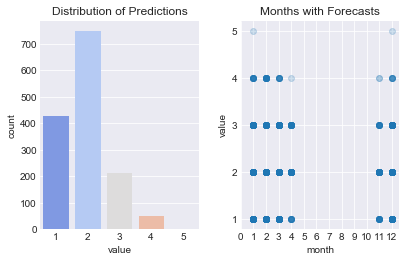

In [11]:
plt.subplot(1, 2, 1);
plt.title('Distribution of Predictions');
sns.countplot(x='value', data=forecasts, palette='coolwarm');
    
plt.subplot(1, 2, 2);
plt.title('Months with Forecasts');
forecasts_month = pd.Series(data = pd.DatetimeIndex(forecasts.index).month);
plt.scatter(forecasts_month, forecasts.value, alpha=0.2);
plt.xticks(range(13)); plt.xlabel('month');
plt.yticks(forecasts.value.unique()); plt.ylabel('value');
plt.tight_layout(pad=2);
    #seasonal forecasting from November - April

## Import Data for Predictor Variables

#### All data is sourced from the National Oceanic and Atmospheric Administration (NOAA)
Data can be found and downloaded at the following site: https://www.ncdc.noaa.gov/cdo-web/

#### Create timeseries DataFrame for analysis 
<ol>
    <li>Read csv files from S3 (data and metadata)</li>
    <li>Seperate station data from weather data</li>
    <li>Remove columns that are information only ("_attribute")
    <li>Assign correct data types to each column</li>
    <li>Use metadata to give columns meaningful names</li>
    <li>Select slice of data from station(s) with the most complete information</li>
    <li>Join to <i>forecasts</i> DataFrame to associate predictors with response for give date</li>
</ol>

In [12]:
# import data from S3 bucket
data = pd.read_csv('https://avalanche-research-model.s3.amazonaws.com/noaa_data.csv')
metadata = pd.read_csv('https://avalanche-research-model.s3.amazonaws.com/noaa_metadata.csv')

In [13]:
# split dataset into STATION DATA and weather data
station_data_raw = data[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']]
station_data_raw = station_data_raw.rename(str.lower, axis=1)
station_data = station_data_raw.drop_duplicates()
station_data = station_data.set_index('station')

print('Station Data:')
display(station_data)
    # weather data comes from 8 distinct stations

Station Data:


,name,latitude,longitude,elevation
station,,,,
US1CANV0047,"TRUCKEE 5.9 ENE, CA US",39.364749,-120.103912,1813.0
USC00048758,"TAHOE CITY, CA US",39.167800,-120.142800,1898.9
US1CAED0020,"SOUTH LAKE TAHOE 4.9 SW, CA US",38.881667,-120.033889,1927.9
USW00093230,"SOUTH LAKE TAHOE AIRPORT, CA US",38.898300,-119.994700,1924.5
USC00049040,"TRUCKEE TAHOE AIRPORT, CA US",39.318000,-120.145000,1798.3
USS0019L45S,"CARSON PASS, CA US",38.690000,-119.990000,2546.0
USS0020K27S,"TAHOE CITY CROSS, CA US",39.170000,-120.150000,2071.7
USS0020K13S,"TRUCKEE NUMBER 2, CA US",39.300000,-120.180000,1983.9


In [14]:
# split dataset into station data and WEATHER DATA
weather_data_raw = data.drop(['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION'], axis=1)
weather_data_raw = weather_data_raw.rename(str.lower, axis=1)

# remove "_attribute" columns
drop_columns = weather_data_raw.columns.to_series().filter(regex='_attributes')
weather_data_raw = weather_data_raw.drop(drop_columns, axis=1)

# change "wt" columns from floats to booleans
flag_columns = weather_data_raw.columns.to_series().filter(regex='wt')
weather_data_raw[flag_columns] = weather_data_raw[flag_columns].fillna(False)
weather_data_raw[flag_columns] = weather_data_raw[flag_columns].replace(1, True)

# change dtype for date
weather_data_raw['date'] = pd.to_datetime(weather_data_raw.date)

print('\t\t\t Weather Data:')
with pd.option_context('display.max_rows',10):
    display(side_by_side(
        [pd.DataFrame(weather_data_raw.dtypes, columns=['New Data Types']),
         weather_data_raw.sort_values('date', ascending=False).head()]))

			 Weather Data:


,New Data Types
station,object
date,datetime64[ns]
awnd,float64
prcp,float64
snow,float64
...,...
wt16,bool
wt17,bool
wt18,bool
wt19,bool


In [15]:
# use metadata to get descriptive column names
metadata_raw = metadata.set_index('Code')
metadata_raw = metadata_raw.rename(str.lower, axis=0)
metadata_raw['Value'] = metadata_raw.Value.str.lower().str.replace(' ', '_')

column_names = metadata_raw.to_dict().get('Value')
weather_data_renamed = weather_data_raw.rename(columns=column_names)

with pd.option_context('display.max_columns',12):
    display(weather_data_renamed.head())

,station,date,average_wind_speed,precipitation,snowfall,snow_depth,...,mist,rain,freezing_rain,snow,unknown_source_of_precipitation,ice_fog_or_freezing_fog
0,US1CANV0047,2017-10-01,NaN,0.0,0.0,NaN,...,False,False,False,False,False,False
1,US1CANV0047,2017-10-02,NaN,0.0,0.0,NaN,...,False,False,False,False,False,False
2,US1CANV0047,2017-10-03,NaN,0.0,0.0,NaN,...,False,False,False,False,False,False
3,US1CANV0047,2017-10-04,NaN,0.0,0.0,NaN,...,False,False,False,False,False,False
4,US1CANV0047,2017-10-05,NaN,0.0,0.0,NaN,...,False,False,False,False,False,False


In [16]:
# understand how data is distributed across stations
column_types = pd.Series(weather_data_renamed.dtypes)

# boolean data
bool_columns = column_types[column_types.values=='bool'].index.tolist()
bool_columns.extend(['station','date'])
grouped_df = weather_data_renamed[bool_columns].groupby('station').nunique()

def highlight_green(x): 
        return ('background-color: lightgreen' if x > 1 else '')
print('Flag Data:')
display(station_data.join(grouped_df).style.applymap(highlight_green, subset=bool_columns))
    # South Lake Tahoe Airport (station "USW00093230") is the only station with complete flag data

print('\n\n')
    
# float data
float_columns = column_types[column_types.values=='float'].index.tolist()
weather_data_no_zeros = weather_data_renamed
weather_data_no_zeros[float_columns] = weather_data_no_zeros[float_columns].replace(0, np.nan)
float_columns.extend(['station', 'date'])
grouped_df = weather_data_renamed[float_columns].groupby('station').count()

def highlight_green(x): 
        max_vals = (x == x.max())
        return ['background-color: lightgreen' if x else '' for x in max_vals]
print('Numeric Data:')
display(station_data.join(grouped_df).style.apply(highlight_green, subset=float_columns))
    # Carson Pass (station "USS0019L45S") has the overall most complete precipitation and temperature data
    # South Lake Tahoe Airport (station "USW00093230") is the only station with wind data

Flag Data:


,name,latitude,longitude,elevation,fog,heavy_fog,thunder,hail,dust,smoke_or_haze,blowing_snow,high_or_damaging_winds,mist,rain,freezing_rain,snow,unknown_source_of_precipitation,ice_fog_or_freezing_fog,station,date
station,,,,,,,,,,,,,,,,,,,,
US1CANV0047,"TRUCKEE 5.9 ENE, CA US",39.3647,-120.104,1813,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,717
USC00048758,"TAHOE CITY, CA US",39.1678,-120.143,1898.9,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,3645
US1CAED0020,"SOUTH LAKE TAHOE 4.9 SW, CA US",38.8817,-120.034,1927.9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1828
USW00093230,"SOUTH LAKE TAHOE AIRPORT, CA US",38.8983,-119.995,1924.5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,3652
USC00049040,"TRUCKEE TAHOE AIRPORT, CA US",39.318,-120.145,1798.3,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,3640
USS0019L45S,"CARSON PASS, CA US",38.69,-119.99,2546,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3652
USS0020K27S,"TAHOE CITY CROSS, CA US",39.17,-120.15,2071.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3652
USS0020K13S,"TRUCKEE NUMBER 2, CA US",39.3,-120.18,1983.9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3652





Numeric Data:


,name,latitude,longitude,elevation,average_wind_speed,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,dir_of_fastest_2min_wind,dir_of_fastest_5sec_wind,water_equivalent_of_snow_on_the_ground,fastest_2min_wind_speed,fastest_5sec_wind_speed,date
station,,,,,,,,,,,,,,,,,
US1CANV0047,"TRUCKEE 5.9 ENE, CA US",39.3647,-120.104,1813,0,164,75,6,0,0,0,0,0,0,0,0,717
USC00048758,"TAHOE CITY, CA US",39.1678,-120.143,1898.9,0,779,385,1083,0,3644,3639,0,0,0,0,0,3645
US1CAED0020,"SOUTH LAKE TAHOE 4.9 SW, CA US",38.8817,-120.034,1927.9,0,426,190,487,0,0,0,0,0,38,0,0,1828
USW00093230,"SOUTH LAKE TAHOE AIRPORT, CA US",38.8983,-119.995,1924.5,3633,805,1,3,0,3634,3624,3647,3603,0,3648,3603,3652
USC00049040,"TRUCKEE TAHOE AIRPORT, CA US",39.318,-120.145,1798.3,0,670,286,843,0,3603,3587,0,0,0,0,0,3640
USS0019L45S,"CARSON PASS, CA US",38.69,-119.99,2546,0,803,0,2107,3652,3652,3646,0,0,2108,0,0,3652
USS0020K27S,"TAHOE CITY CROSS, CA US",39.17,-120.15,2071.7,0,747,0,1302,3650,3650,3650,0,0,1295,0,0,3652
USS0020K13S,"TRUCKEE NUMBER 2, CA US",39.3,-120.18,1983.9,0,789,0,1635,3651,3651,3649,0,0,1644,0,0,3652


In [17]:
# combine South Lake Tahoe Airport with select Carson Pass data
slta_data = weather_data_renamed[weather_data_renamed.station=="USW00093230"]
slta_data = slta_data.set_index('date')

cp_columns = ['precipitation','snowfall','snow_depth','avg_temp','max_temp','min_temp', 'water_equivalent_of_snow_on_the_ground']
cp_data = weather_data_renamed[weather_data_renamed.station=="USS0019L45S"]
cp_data = cp_data.set_index('date')

slta_data.update(cp_data[cp_columns])
slta_data = slta_data.drop('station', axis=1)

display(slta_data.count())

average_wind_speed                        3633
precipitation                              992
snowfall                                     1
snow_depth                                2107
avg_temp                                  3652
max_temp                                  3652
min_temp                                  3651
dir_of_fastest_2min_wind                  3647
dir_of_fastest_5sec_wind                  3603
water_equivalent_of_snow_on_the_ground    2108
fastest_2min_wind_speed                   3648
fastest_5sec_wind_speed                   3603
fog                                       3652
heavy_fog                                 3652
thunder                                   3652
hail                                      3652
dust                                      3652
smoke_or_haze                             3652
blowing_snow                              3652
high_or_damaging_winds                    3652
mist                                      3652
rain         

In [18]:
# join in response variable
predictor_data = slta_data.merge(forecasts, left_index=True, right_index=True, how='right')
with pd.option_context('display.max_columns',10):
    display(predictor_data.head())
print('Final number of records: ', predictor_data.shape[0])

,average_wind_speed,precipitation,snowfall,snow_depth,avg_temp,...,freezing_rain,snow,unknown_source_of_precipitation,ice_fog_or_freezing_fog,value
date,,,,,,,,,,,
2010-01-01,8.95,0.1,NaN,36.0,33.0,...,False,True,False,False,2
2010-01-02,2.46,NaN,NaN,36.0,27.0,...,False,False,False,False,2
2010-01-03,2.24,NaN,NaN,33.0,33.0,...,False,False,False,False,1
2010-01-04,2.24,NaN,NaN,35.0,33.0,...,False,False,False,False,1
2010-01-05,1.79,NaN,NaN,34.0,32.0,...,False,False,False,False,1


Final number of records:  1442


## Analyze and Clean Feature Set

### Time for the fun stuff!

#### Analyze distributions of each existing feature
<ol>
    <li>Plot histograms of each continuous (float) variable</li>
    <li>Plot histograms of each discrete (boolean) variable</li>
    <li>Drop features that are majority missing</li>
</ol>

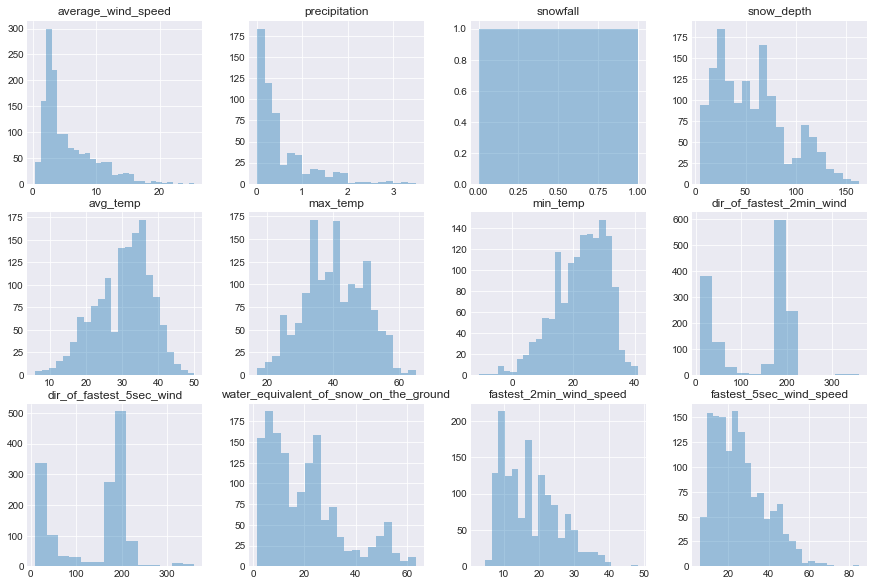

In [19]:
# plot distribution of float fields
column_types = pd.Series(predictor_data.dtypes)
float_columns = column_types[column_types.values=='float'].index.tolist()

#predictor_data.describe();

i=0
for c in float_columns:
    i=i+1
    _=plt.subplot(3, 4, i);
    _=plt.title(c);
    _=sns.distplot(predictor_data[c].dropna(), kde=False);
    _=plt.xlabel('');
    _=plt.tight_layout(pad=0.2);
    fig = plt.gcf();
    fig.set_size_inches(12,8);

In [20]:
# snowfall only has one non-n/a value - drop this column
predictor_data_clean = predictor_data.drop('snowfall', axis=1)

 fog :  18.31 % True
 heavy_fog :  8.81 % True
 thunder :  0.0 % True
 hail :  2.15 % True
 dust :  0.69 % True
 smoke_or_haze :  16.3 % True
 blowing_snow :  2.36 % True
 high_or_damaging_winds :  0.83 % True
 mist :  7.84 % True
 rain :  11.65 % True
 freezing_rain :  0.07 % True
 snow :  14.08 % True
 unknown_source_of_precipitation :  1.94 % True
 ice_fog_or_freezing_fog :  4.99 % True


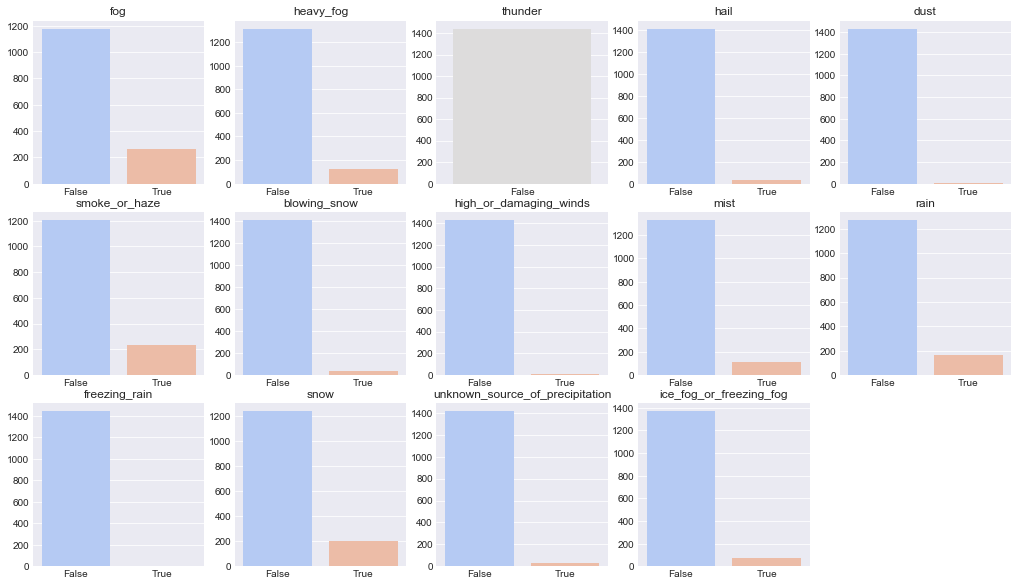

In [21]:
# plot distribution of boolean fields
bool_columns = column_types[column_types.values=='bool'].index.tolist()

i=0
emply_columns = []
for c in bool_columns:
    color = 30
    i=i+1
    _=plt.subplot(3, 5, i);
    _=plt.title(c);
    _=sns.countplot(x=c, data=predictor_data, palette='coolwarm');
    _=plt.xlabel(''); _=plt.ylabel('');
    _=plt.tight_layout(pad=0.2);
    fig = plt.gcf();
    fig.set_size_inches(14,8);
    
    perc_true = round(len(predictor_data.loc[:,c][predictor_data.loc[:,c]==True]) / len(predictor_data.loc[:,c])*100, 2)
    if perc_true < 1:
        emply_columns.append(c)
        color = 31
    print('\033[;%sm' % color, c, ': ', perc_true, '% True')

In [22]:
# drop all columns that are <1% True  (noted in red above)
predictor_data_clean = predictor_data_clean.drop(emply_columns, axis=1)

In [23]:
predictor_data_clean.columns

Index(['average_wind_speed', 'precipitation', 'snow_depth', 'avg_temp',
       'max_temp', 'min_temp', 'dir_of_fastest_2min_wind',
       'dir_of_fastest_5sec_wind', 'water_equivalent_of_snow_on_the_ground',
       'fastest_2min_wind_speed', 'fastest_5sec_wind_speed', 'fog',
       'heavy_fog', 'hail', 'smoke_or_haze', 'blowing_snow', 'mist', 'rain',
       'snow', 'unknown_source_of_precipitation', 'ice_fog_or_freezing_fog',
       'value'],
      dtype='object')

#### Generate features based on above analysis
<ol>
    <li>Wind Direction Variables: both direction of wind variables have very non-normal distributions. It may be more meaningful to change this variable from continuous to categorical by translating the numeric direction into the cardinal direction {N,E,S,W} </li>
    <li>Temperature Variables: change in temperature is very important for avalanche preditions. Create new features (daily delta, moving average, moving delta) to look at change over time</li>
</ol>

In [24]:
# Wind Direction Variables
predictor_data_wind = predictor_data_clean
wind_dir_columns = ['dir_of_fastest_2min_wind', 'dir_of_fastest_5sec_wind']

# function to bin numeric directions into cardial directions
def cardinal_direction(values):
    new_values = []
    for val in values:
        if val>=45 and val<135: new_values.append('E')
        elif val>=135 and val<255: new_values.append('S')
        elif val>=255 and val<315: new_values.append('W')
        elif val>=315 or val<45: new_values.append('N')
        else: np.nan
    return new_values

predictor_data_wind[wind_dir_columns[0]+'_card'] = cardinal_direction(predictor_data_wind[wind_dir_columns[0]].fillna(500))
predictor_data_wind[wind_dir_columns[1]+'_card'] = cardinal_direction(predictor_data_wind[wind_dir_columns[1]].fillna(500))
wind_dir_columns.extend([wind_dir_columns[0]+'_card', wind_dir_columns[1]+'_card'])

print('Wind direction columns:')
display(predictor_data_wind[wind_dir_columns].head())

# reduce dimensionality by choosing one generated field
print('Records with different wind directions: ', 
      predictor_data_wind[wind_dir_columns].where(predictor_data_wind.dir_of_fastest_2min_wind_card!=predictor_data_clean.dir_of_fastest_5sec_wind_card).dropna().shape[0])
# less than 10% of records are different - let's combine these fields (use sustained wind's direction)
predictor_data_wind['dir_of_wind'] = predictor_data_wind.dir_of_fastest_2min_wind_card
predictor_data_wind = predictor_data_wind.drop(wind_dir_columns, axis=1)

print('\nFinal wind direction column:')
display(predictor_data_wind[['dir_of_wind']].head())

Wind direction columns:


,dir_of_fastest_2min_wind,dir_of_fastest_5sec_wind,dir_of_fastest_2min_wind_card,dir_of_fastest_5sec_wind_card
date,,,,
2010-01-01,180.0,180.0,S,S
2010-01-02,200.0,220.0,S,S
2010-01-03,30.0,30.0,N,N
2010-01-04,30.0,30.0,N,N
2010-01-05,30.0,30.0,N,N


Records with different wind directions:  112

Final wind direction column:


,dir_of_wind
date,
2010-01-01,S
2010-01-02,S
2010-01-03,N
2010-01-04,N
2010-01-05,N


In [25]:
# Temperature Variables
predictor_data_temp = predictor_data_wind
temp_columns = predictor_data_temp.filter(regex='temp').columns

# check for NAs
predictor_data_temp[temp_columns].isnull().sum()
    # one missing value for min_temp - calculate from max and average
predictor_data_temp.loc[predictor_data_temp.min_temp.isnull(), 'min_temp'] = predictor_data_temp.loc[predictor_data_temp.min_temp.isnull(), 'max_temp'] - (2 * predictor_data_temp.loc[predictor_data_temp.min_temp.isnull(), 'avg_temp'])

# change in day's temperature
predictor_data_temp['delta_temp'] = predictor_data_temp.max_temp - predictor_data_temp.min_temp
# three-day moving average of avg_temp
predictor_data_temp['temp_3_day_ma'] = predictor_data_temp.avg_temp.rolling(3).mean()
# seven-day moving average of avg_temp
predictor_data_temp['temp_7_day_ma'] = predictor_data_temp.avg_temp.rolling(7).mean()
# three-day moving difference of avg_temp
predictor_data_temp['temp_1_day_md'] = predictor_data_temp.avg_temp.diff(periods=1)
# seven-day moving difference of avg_temp
predictor_data_temp['temp_3_day_md'] = predictor_data_temp.avg_temp.diff(periods=3)

# fill start of moving calculations with substitute values
predictor_data_temp = predictor_data_temp.fillna({
                                                 'temp_3_day_ma': predictor_data_temp.avg_temp, 
                                                 'temp_7_day_ma': predictor_data_temp.avg_temp, 
                                                 'temp_1_day_md': 0, 
                                                 'temp_3_day_md': 0})

print('\n\nTemperature Columns')
display(side_by_side([
    predictor_data_temp.filter(regex='temp').head(),
    predictor_data_temp.filter(regex='temp').tail()]))

avg_temp    0
max_temp    0
min_temp    1
dtype: int64



Temperature Columns


,avg_temp,max_temp,min_temp,delta_temp,temp_3_day_ma,temp_7_day_ma,temp_1_day_md,temp_3_day_md
date,,,,,,,,
2010-01-01,33.0,35.0,31.0,4.0,33.000000,33.0,0.0,0.0
2010-01-02,27.0,40.0,16.0,24.0,27.000000,27.0,-6.0,0.0
2010-01-03,33.0,48.0,23.0,25.0,31.000000,33.0,6.0,0.0
2010-01-04,33.0,46.0,26.0,20.0,31.000000,33.0,0.0,0.0
2010-01-05,32.0,44.0,26.0,18.0,32.666667,32.0,-1.0,5.0
,avg_temp,max_temp,min_temp,delta_temp,temp_3_day_ma,temp_7_day_ma,temp_1_day_md,temp_3_day_md
date,,,,,,,,
2019-12-27,17.0,28.0,9.0,19.0,19.000000,27.142857,-3.0,-10.0
2019-12-28,24.0,37.0,13.0,24.0,20.333333,25.428571,7.0,4.0


#### Normalize continuous variables
<ol>
    <li>Replace missing values with 0 - can assume the lack of data entry is meaningful (i.e. weather condition was not observed)</li>
    <li>Transform skewed variables with a Box-Cox Transformation</li>
    <li>Standardize all continuous (float) features</li>
</ol>

In [26]:
# replace missing values
predictor_data_cont = predictor_data_temp
column_types = pd.Series(predictor_data_cont.dtypes)
float_columns = column_types[column_types.values=='float'].index.tolist()

predictor_data_cont[float_columns] = predictor_data_cont[float_columns].fillna(0)

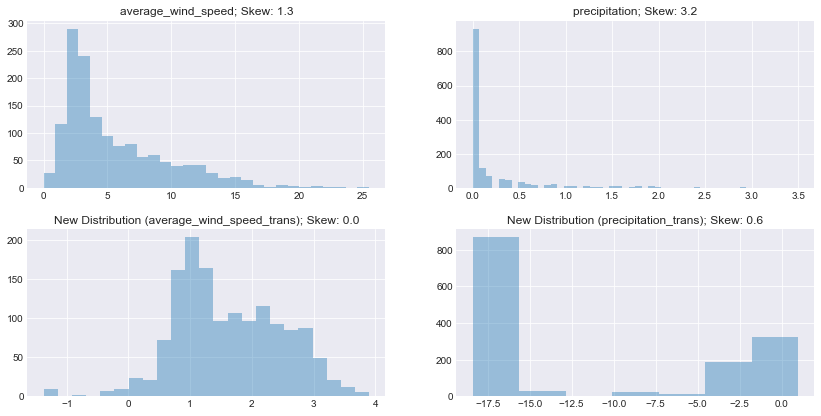

In [27]:
# transform severly skewed variables
predictor_data_unskew = predictor_data_cont

# get all variables with skew >1 OR <-1
skewed_vars = predictor_data_unskew[float_columns].skew()[abs(predictor_data_unskew[float_columns].skew())>1].index.tolist()

i=0
for c in skewed_vars:
    # plot original distribution
    i=i+1
    _=plt.subplot(2, len(skewed_vars), i)
    _=plt.title(c + '; Skew: ' + str(predictor_data_unskew[c].skew().round(1)))
    _=sns.distplot(predictor_data_unskew[c], kde=False)
    _=plt.xlabel('')

    # replace 0s with half of smallest value
    zero_replace = predictor_data_unskew[c][predictor_data_unskew[c]!=0].min()/2
    # transform using Box-Cox method
    transform = boxcox(predictor_data_unskew[c].apply(lambda x: zero_replace if x==0 else x))
    transform_ser = pd.Series(data = transform[0], index = predictor_data_unskew.index)
    predictor_data_unskew[c+'_trans'] = transform_ser
    
    # plot transformed distribution
    _=plt.subplot(2, len(skewed_vars), i+len(skewed_vars))
    _=plt.title('New Distribution (' +c+'_trans); Skew: ' + str(predictor_data_unskew[c+'_trans'].skew().round(1)))
    _=sns.distplot(predictor_data_unskew[c+'_trans'], kde=False)
    _=plt.xlabel('')
    _=plt.tight_layout(pad=1.5)
    fig = plt.gcf()
    fig.set_size_inches(12,6)    

# drop original columns
predictor_data_unskew = predictor_data_unskew.drop(skewed_vars, axis=1)   

In [28]:
# standardize float columns
predictor_data_std = predictor_data_unskew
column_types = pd.Series(predictor_data_std.dtypes)
float_columns = column_types[column_types.values=='float'].index.tolist()

# define function for mean standardization
def normalize(df):
    columns = df.columns
    output_df = df
    for c in columns: 
        output_df[c+'_std'] = (df[c] - df[c].mean()) / df[c].std()
        output_df = output_df.drop(c, axis=1)
    return output_df
standardized_columns = normalize(predictor_data_std[float_columns])

# join output of fucntion to working DF
predictor_data_std = standardized_columns.join(predictor_data_std)
# drop original columns
predictor_data_std = predictor_data_std.drop(float_columns, axis=1)

display(side_by_side([
pd.DataFrame(data={
    'var': predictor_data_unskew[float_columns].columns,
    'mean': predictor_data_unskew[float_columns].mean().values.round(), 
    'st_dev': predictor_data_unskew[float_columns].std().values}),
pd.DataFrame(data={
    'var': predictor_data_std.filter(regex='_std').columns,
    'mean': predictor_data_std.filter(regex='_std').mean().values.round(), 
    'st_dev': predictor_data_std.filter(regex='_std').std().values})]))

,var,mean,st_dev
0,snow_depth,57.0,34.972916
1,avg_temp,30.0,7.666292
2,max_temp,40.0,9.141874
3,min_temp,23.0,8.481730
4,water_equivalent_of_snow_on_the_ground,20.0,14.585061
5,fastest_2min_wind_speed,18.0,7.861015
6,fastest_5sec_wind_speed,25.0,12.813972
7,delta_temp,18.0,6.710585
8,temp_3_day_ma,30.0,6.774015
9,temp_7_day_ma,30.0,5.623219


## Data Science!

### Time for the <i>really</i> fun stuff!

#### Define the variables
<ul>
    <li>y is the response variable (1-5) that was scraped from the SAC site</li>
    <li>X are the predictor variables (continuous and categorical) that were generated in the above section</li>

In [29]:
y = predictor_data_std.value
X = predictor_data_std.drop(['value'], axis=1)

#### One-Hot Encoding
<ul>
    <li>Refactor multi-level categorical varaible (<i>dir_of_wind</i>) to numeric with dummy variables

In [30]:
# refactor cardinal direction column using dummy variables (ohe)
wind_var_ohe = pd.get_dummies(X['dir_of_wind'], prefix='dir_of_wind')
print('Count of each direction: ')
wind_var_ohe.sum() # south winds will be our base case

X = X.join(wind_var_ohe)
# drop original column and base case
X = X.drop(['dir_of_wind', 'dir_of_wind_S'], axis=1)

display(X.filter(regex='dir_of_wind', axis=1).head())

Count of each direction: 


dir_of_wind_E     71
dir_of_wind_N    481
dir_of_wind_S    889
dir_of_wind_W      1
dtype: int64

,dir_of_wind_E,dir_of_wind_N,dir_of_wind_W
date,,,
2010-01-01,0,0,0
2010-01-02,0,0,0
2010-01-03,0,1,0
2010-01-04,0,1,0
2010-01-05,0,1,0


#### Feature selection
<ol>
    <li>Conduct recursive feature elimination with a linear regression model (out of curiousity)</li>
    <li>Conduct recursive feature elimination with a random forest model (to get a better map of the effect of our features)</li>
</ol>

In [31]:
# Recursive Feature Elimination (linear regression)
linreg = LinearRegression()
rfe = RFE(linreg,1)
rfe = rfe.fit(X.astype(float), y)

# pair the rankings with their feature names in a dataframe
ranked = pd.DataFrame(index=np.arange(0, len(X.columns)), columns=['vars', 'lr_ranking'])
ranked.vars = X.columns
ranked.lr_ranking = rfe.ranking_
ranked = ranked.set_index('vars')

# show top half of features sorted by their ranking
display(ranked.sort_values('lr_ranking').iloc[0:int(X.shape[1]/2),:])

,lr_ranking
vars,
snow_depth_std,1
water_equivalent_of_snow_on_the_ground_std,2
precipitation_trans_std,3
dir_of_wind_E,4
hail,5
dir_of_wind_W,6
max_temp_std,7
avg_temp_std,8
min_temp_std,9


In [32]:
# Recursive Feature Elimination (random forest)
rf = RandomForestClassifier(n_estimators=200, max_depth=int(X.shape[1]/2))
rf = rf.fit(X, y)

# join rankings to dataframe
rf_ranking = pd.Series(data = rf.feature_importances_, index = X.columns, name='rf_ranking')
ranked = ranked.join(rf_ranking)

# show top half of features sorted by their rk ranking
display(ranked.sort_values('rf_ranking',ascending=False).iloc[0:int(X.shape[1]/2),:])

,lr_ranking,rf_ranking
vars,,
snow_depth_std,1,0.108166
precipitation_trans_std,3,0.106491
water_equivalent_of_snow_on_the_ground_std,2,0.102582
max_temp_std,7,0.072460
average_wind_speed_trans_std,11,0.065974
temp_7_day_ma_std,18,0.061785
temp_3_day_ma_std,22,0.059453
fastest_5sec_wind_speed_std,13,0.059050
temp_1_day_md_std,21,0.053743


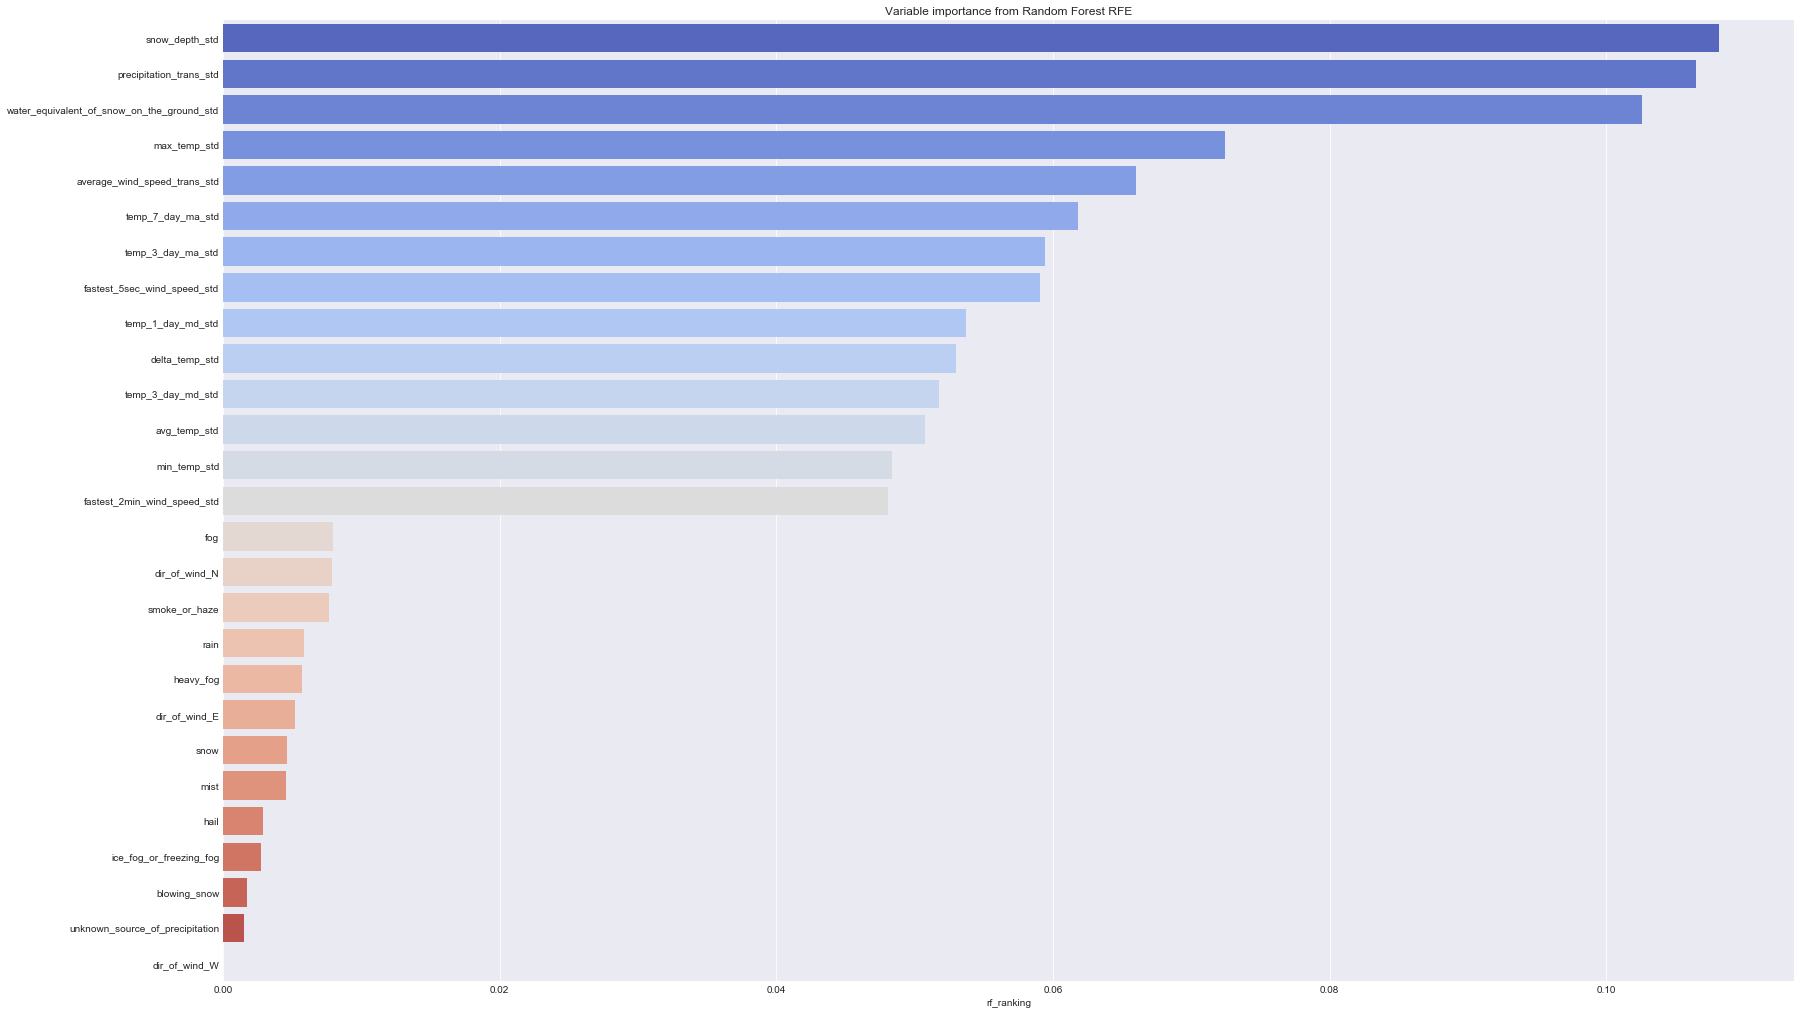

In [33]:
# plot variable importance
_=sns.factorplot(y = ranked.sort_values('rf_ranking',ascending=False).index, x = "rf_ranking", data=ranked.sort_values('rf_ranking',ascending=False), 
               kind="bar", size=14, aspect=1.9, palette='coolwarm');
_=plt.title('Variable importance from Random Forest RFE')
_=plt.ylabel('');

#### Model Building
<ol>
    <li>Split into test/training sets using k-fold cross-validation - because the distribution of our response variable isn't uniform, use stratified k-fold</li>
    <li>Train a random forest classifier on each fold</li>
</ol>

Train Size: 1200   Test Size: 242
Train Size: 1200   Test Size: 242
Train Size: 1201   Test Size: 241
Train Size: 1203   Test Size: 239
Train Size: 1202   Test Size: 240
Train Size: 1204   Test Size: 238


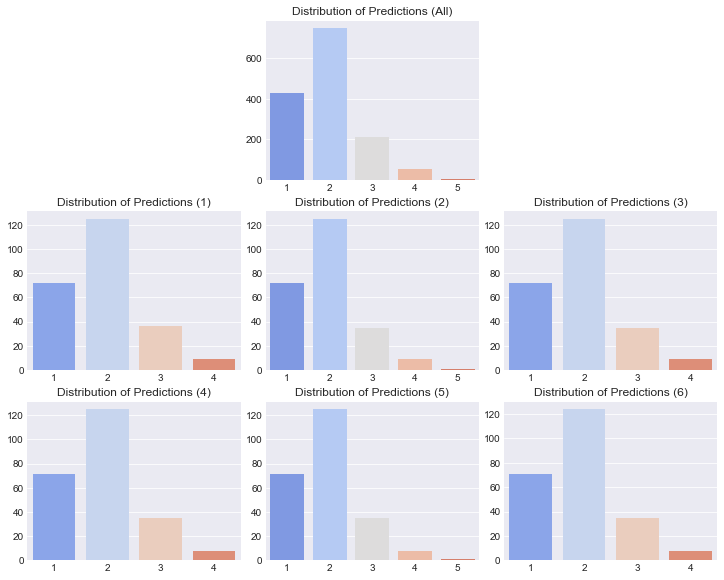

In [34]:
# split into test and training sets 
skf = StratifiedKFold(n_splits=6, shuffle=True)

y_df = pd.DataFrame(data={'date': y.index, 'val': y.values}, 
                    columns=['date', 'val', 'y_pred', 'proba_1', 'proba_2', 'proba_3', 'proba_4', 'proba_5', 'k_fold'])

# plot distributions of response variable for overall dataset
_=plt.subplot(3, 3, 2);
_=plt.title('Distribution of Predictions (All)');
_=sns.countplot(x="val", data=y_df, palette='coolwarm');
_=plt.xlabel(''); _=plt.ylabel('');

# plot distributions of response variable for each fold
i=0
for train_index, test_index in skf.split(X, y):
    i=i+1
    print("Train Size:", len(train_index), "  Test Size:", len(test_index))
    _=plt.subplot(3, 3, i+3);
    _=sns.countplot(x="val", data=y_df[y_df.index.isin(test_index)], palette='coolwarm');
    _=plt.title('Distribution of Predictions ('+str(i)+')');
    _=plt.xlabel(''); _=plt.ylabel('');
    _=plt.tight_layout(pad=0.5);
    fig = plt.gcf()
    fig.set_size_inches(10,8)

In [35]:
# Trian rf classifier
rf_train = RandomForestClassifier(n_jobs=2, n_estimators=200, max_depth=int(X.shape[1]/2))

i=0
for train_index, test_index in skf.split(X, y):
    i=i+1
    
    # fit classifier to each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_train = rf_train.fit(X_train, y_train)
    
    # run preditions on test set
    y_pred = rf_train.predict(X_test)
    y_pred_proba = rf_train.predict_proba(X_test)
    # write results to dataframe
    y_results = pd.DataFrame(index=test_index,
                             data={'y_pred': y_pred, 
                             'proba_1': np.hsplit(y_pred_proba,5)[0].reshape(1,len(y_pred_proba))[0],
                             'proba_2': np.hsplit(y_pred_proba,5)[1].reshape(1,len(y_pred_proba))[0],
                             'proba_3': np.hsplit(y_pred_proba,5)[2].reshape(1,len(y_pred_proba))[0],
                             'proba_4': np.hsplit(y_pred_proba,5)[3].reshape(1,len(y_pred_proba))[0],
                             'proba_5': np.hsplit(y_pred_proba,5)[4].reshape(1,len(y_pred_proba))[0],
                             'k_fold': i})
    y_df.loc[test_index, ['y_pred', 'proba_1', 'proba_2', 'proba_3', 'proba_4', 'proba_5','k_fold']] = y_results

display(side_by_side([
    y_df.head(),
    y_df.filter(regex='y_pred').groupby(y_df.k_fold).count()]))

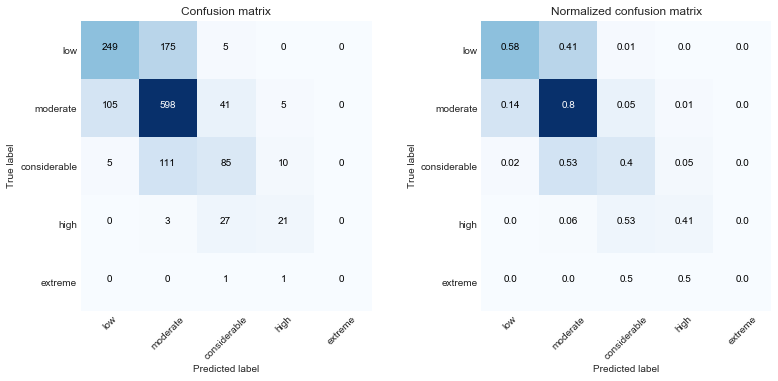

In [36]:
# define function to plot confustion matrix object
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    
    # plot colors for frequency of values 
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap);
    #plt.colorbar();
    tick_marks = np.arange(len(classes));
    plt.xticks(tick_marks, classes, rotation=45);
    plt.yticks(tick_marks, classes);
    plt.grid(False);

    # calculate ratios for normalized cm
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = 0.7
        plt.title("Normalized confusion matrix")   
    else:
        thresh = cm.max() / 2
        plt.title("Confusion matrix")

    #print(cm)

    # print labels on cm plot (either ratio (if normalize) or counts)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black");

    plt.tight_layout(pad=5);
    plt.ylabel('True label');
    plt.xlabel('Predicted label');
   

# create and plot matrix for rf classifier
cm = metrics.confusion_matrix(y_df.val, y_df.y_pred);

plt.subplot(1,2,1);
plot_confusion_matrix(cm, y_key.values);
plt.subplot(1,2,2);
plot_confusion_matrix(cm, y_key.values, normalize=True);

Overall accuracy of random forest classifier:  66.09% 



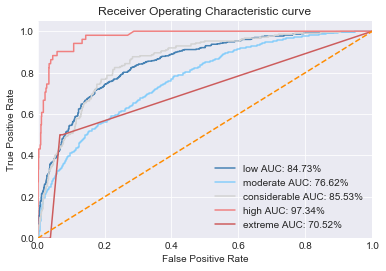

In [37]:
# print model's overall accuracy
print('Overall accuracy of random forest classifier: ', '{:.2%}'.format(metrics.accuracy_score(y_df.val, y_df.y_pred,2)), '\n')

# plot ROC curve for each level of response
colors = ['steelblue', 'lightskyblue', 'lightgray', 'lightcoral', 'indianred']
for i in y_key.index:
    fpr, tpr, thresholds = metrics.roc_curve(y_df.val, y_df['proba_'+str(i)], pos_label=i)
    roc_score = metrics.roc_auc_score(y_df.val.apply(lambda x:True if x==i else False), y_df['proba_'+str(i)])
    plt.plot(fpr, tpr, 
             label=y_key[i]+' AUC: {:.2%}'.format(roc_score),
             color=colors[i-1]);
plt.title('Receiver Operating Characteristic curve');
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--');
plt.xlabel('False Positive Rate'); plt.xlim([0, 1.0]); 
plt.ylabel('True Positive Rate'); plt.ylim([0, 1.05]);
plt.legend(loc="lower right");

# Conclusion

The overall accuracy of our random forest model is adequate. According to our AUC metrics, our model is better at distinguising the differences between class for less frequently observed forecasts. However, this value could be skewed because our model was biased away from predicting the less frequent forecast values, making the false positive rate for these classes very low. <br><br>
<b>Next Steps:</b><br>
There are still a number of critical steps missing from this notebook. The following questions pose opportunity for further development to improve our model and create a more robust classification.
<ul>
    <li>What other predictors beyond weather might be relevant for inclusion?</li>
    <li>Is there a more meaningful way to combine data from different weather stations to create a wholistic view of weather patterns in the area?</li>
    <li>Should we decrease our number of test/train folds to k=2 so all training sets contain one instance of each possible forecast value?</li>
    <li>How can we tune our random forest to improve performance: increase tree depth? increase/decrease # of trees in forest?
    <li>What other classification models can we fit to our data in order to obtain a higher accuracy: Gradient Boosting Classifier? Support Vector Classifier?</li>
    <li>What metrics are most important when evaluating our model(s)? Should our model air on the side of caution (i.e. recall is more valuable than precision, especially at higher risk values)? </li>
</ul>

<b>Parting Thoughts:</b> Stick to the professionals' recommendations and <i>always</i> check your local avalanche forecast before you hit the backcountry.